# Activations Gradients and Batch Normalization

This notebook is from part 3 of lecture notes from "Neural Networks: Zero to hero" series. [Lecture link](https://www.youtube.com/watch?v=P6sfmUTpUmc)

This lecture explores the effect of initialization on the gradients and the activations. And how initializations and batch normalizations are helpful in mitigating the issues. 

1. [Intial training loss and Tanh saturations](#initial-loss-tanh-saturations)
2. [Kaiming init](#kaiming-init)




| Initialization   | Initial Loss | Train loss | Val loss | Remarks |
|------------------|------------|----------| -- | -- |
| Random Normal    | 27.881 | 2.126      | 2.169    | Original |
| b2 * 0, W2 * 0.01    | 3.322 | 2.069 | 2.131 | Fix initial loss at output layer |
| b2 * 0, W2 * 0.01, b1 * 0.01, W1 * 0.2    | 3.313 | 2.035 | 2.102 | Fix tanh layer too saturated at init |
| Kaiming | 3.317 | 2.037 | 2.106 | Systematic method to fix tanh saturations |
| Batch Normalization | 3.314 | 2.066 | 2.104 | Standerdize the preactivation ouptut |

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Load Data

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
print(f"{len(words)=}")

len(words)=32033


## Helpers

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build Dataset

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


<a id="initial-loss-tanh-saturations"></a>
## 1. Initial loss and Tanh saturations

### MLP Model

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0  

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


### Training

In [7]:
max_steps = 200_000
batch_size = 32
lossi = []


for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed characters to vector (batch_size, block_size, n_embd)==(32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    hact = torch.tanh(hpreact) # tanh activation of hidden layer
    logits = hact @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters: # zero grad
        p.grad = None

    loss.backward()

    # update grads
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f'{i:7d}/{max_steps:7d} = {loss.item():.4f}')
    lossi.append(loss.log().item())


      0/ 200000 = 3.3135
  10000/ 200000 = 2.1648
  20000/ 200000 = 2.3061
  30000/ 200000 = 2.4541
  40000/ 200000 = 1.9787
  50000/ 200000 = 2.2930
  60000/ 200000 = 2.4232
  70000/ 200000 = 2.0680
  80000/ 200000 = 2.3095
  90000/ 200000 = 2.1207
 100000/ 200000 = 1.8269
 110000/ 200000 = 2.2045
 120000/ 200000 = 1.9797
 130000/ 200000 = 2.3946
 140000/ 200000 = 2.1000
 150000/ 200000 = 2.1948
 160000/ 200000 = 1.8619
 170000/ 200000 = 1.7809
 180000/ 200000 = 1.9673
 190000/ 200000 = 1.8295


In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


### Gradients and Activation

The hidden layer has the `tanh` activations to introduce the non-linearity in networks. `tanh` functions varies between **-1** to **+1**. Any values greater or lesser than these +1 or -1 are squashed to +1 and - 1 respectively.

Histogram of pre-activations of MLP. It ranges between -15 to +15 

![Hidden layer pre-activation distribution](hidden_preact.png)

After `tanh` activation 

![Distribuion of Hidden layer tanh activation](hidden_act.png)

We can clearly see the -1 and +1 are dominant values after `tanh` activation. This is a huge problem during backpropagation as The neurons with -1 and +1 outputs results in a zero gradient (or the gradient vanishes). The consequence of this is there is no update to the learning the parameters (weigths and biases) during the update step. 

#### What can we do?

**Initialize the weigths and biases of the hidden layer to low values so that preactivation computation does not lead to huge variance.**

Initializing weights and biases to random values and multiplying weight by factor of **0.2** and biases by factor of **0.01** results in following distributions.

Preactivation

![Hidden layer pre-activation after scaling](hidden_preact_good.png)

`tanh` activation

![Hidden layer activated after scaling](hidden_act_good.png)



### Remarks:

1. Initializing the neural network weights to all random values results in initial loss of `27.8817`. 
    - This is too high. Ideally, we want a network to think each of 27 character is equally likely. Which means the loss should be $$nll(\frac{1}{27}) = -log(\frac{1}{27})= 3.2958$$
2. Setting the output layer biases to zero and weights to very small values by multiplying them by a factor of 0.01

<a id="kaiming-init"></a>
## Kaiming Init

From previous section we learned that initializing the weights and biases of output layer, grounds the network from being over-confident on it's prediction during the initial loop. The hidden layer initializations causes the outputs to be very far in tails of tanh which creates the problem for network to learn parameters. So we have handpicked the initialization weights as `0.2` by analysing the results of first batch. This implies everytime we train the network we need to tune the parameter initializations of the hiddne layer(s). 

**Kaiming Initialization** provide a standart approach to initialize the paramters to overcome these issues.

[Link to paper](https://arxiv.org/pdf/1502.01852)

### Intuition

x.mean()=tensor(0.0169), x.std()=tensor(0.9965)
y.mean()=tensor(0.0010), y.std()=tensor(1.0135)


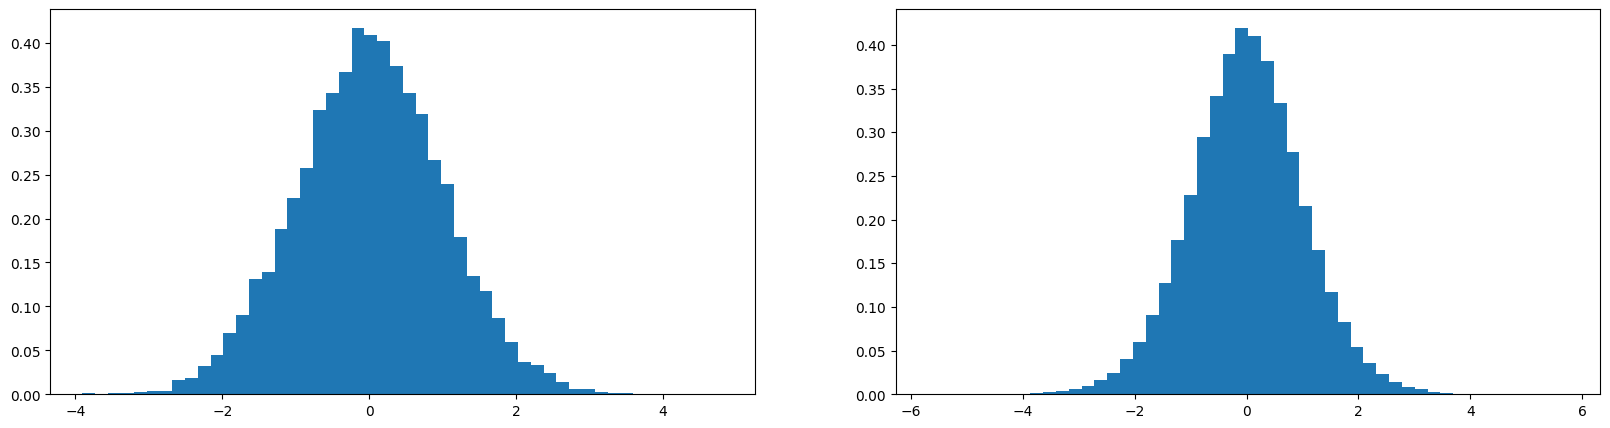

In [9]:
x = torch.randn(1000, 10) # 1000 samples, 10 inputs
w = torch.randn(10, 200) / 10**0.5  # 10 inputs, 200 neurons
y = x @ w
print(f"{x.mean()=}, {x.std()=}")
print(f"{y.mean()=}, {y.std()=}")
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

With x and w initialized ot standard normal distribution (mean=0, std=1), when we multiply the of `x` and `w` we can see the **mean remains same but the standard deviation increases/expands**. The expansion of the output distribution will result in tanh saturations.

Inorder to control std. of the output distribvution we need to multiply the weights intializations by a factor. Kaiming's initializations helps to mainitain the standard deviations of the output distribution. Check the pytorch [documentation](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) for differnt initialization settings.

In our example we intialize by multiplying the factor $\sqrt{1/fan_{in}}$ (where $fan_{in}$ is number of inputs to layer/neuron).

### MLP Model

In [10]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd*block_size)**0.5 # Kaiming_normal factor
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0  

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


### Training

In [11]:
max_steps = 200_000
batch_size = 32
lossi = []


for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed characters to vector (batch_size, block_size, n_embd)==(32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    hact = torch.tanh(hpreact) # tanh activation of hidden layer
    logits = hact @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters: # zero grad
        p.grad = None

    loss.backward()

    # update grads
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f'{i:7d}/{max_steps:7d} = {loss.item():.4f}')
    lossi.append(loss.log().item())


      0/ 200000 = 3.3179
  10000/ 200000 = 2.1910
  20000/ 200000 = 2.3270
  30000/ 200000 = 2.5396
  40000/ 200000 = 1.9468
  50000/ 200000 = 2.3331
  60000/ 200000 = 2.3852
  70000/ 200000 = 2.1173
  80000/ 200000 = 2.3159
  90000/ 200000 = 2.2010
 100000/ 200000 = 1.8591
 110000/ 200000 = 2.0881
 120000/ 200000 = 1.9389
 130000/ 200000 = 2.3913
 140000/ 200000 = 2.0949
 150000/ 200000 = 2.1458
 160000/ 200000 = 1.7824
 170000/ 200000 = 1.7249
 180000/ 200000 = 1.9751
 190000/ 200000 = 1.8614


In [12]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


## Batch Normalizations

In 2025 initialzing the parameters precisely is not important anymore due to the modern innovations. Batch Normalizations is one such innovation that helps mitigate the tanh saturations.

Batch Normalization is a simple and straight forward idea developed by team in google. Standardize (subtract mean and divide by std.dev) the outputs over the mini-batch. 

![Batch norm](batch_norms.png)

### MLP Model

In [26]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd*block_size)**0.5 # Kaiming_normal factor
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0  

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] #[C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


### Training

In [ ]:
max_steps = 200_000
batch_size = 32
lossi = []


for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed characters to vector (batch_size, block_size, n_embd)==(32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    # Batch norm layer
    # ---------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------------------------------
    # Tanh non-linearity
    hact = torch.tanh(hpreact) # tanh activation of hidden layer
    logits = hact @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters: # zero grad
        p.grad = None
    loss.backward()

    # update grads
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f'{i:7d}/{max_steps:7d} = {loss.item():.4f}')
    lossi.append(loss.log().item())


      0/ 200000 = 3.3147
  10000/ 200000 = 2.1984
  20000/ 200000 = 2.3375
  30000/ 200000 = 2.4359
  40000/ 200000 = 2.0119
  50000/ 200000 = 2.2595
  60000/ 200000 = 2.4775
  70000/ 200000 = 2.1020
  80000/ 200000 = 2.2788
  90000/ 200000 = 2.1862
 100000/ 200000 = 1.9474
 110000/ 200000 = 2.3010
 120000/ 200000 = 1.9837
 130000/ 200000 = 2.4523
 140000/ 200000 = 2.3839
 150000/ 200000 = 2.1987
 160000/ 200000 = 1.9733
 170000/ 200000 = 1.8668
 180000/ 200000 = 1.9973
 190000/ 200000 = 1.8347


In [22]:
# calibrate batch norm at end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [23]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5859,  1.2261, -1.0111,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6724,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2112, -0.3226,  

In [24]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1356,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2864,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0699, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2298,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8614,  0.8118,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6269,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

`bnmean` and `bnmean_running` should be approximately the same. This is similar intuition behined the std dev too.

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


#### Second order effect of Batch normalization

Prior to Batch normalization, one input sample only impacts its logits at the output. Since we are batch normalizing the preactivation outputs based on all samples in mini-batch (we are mathematically tying other samples in mini-batch to this sample). The other samples that have come in for the ride has impact on the output of batch norm and so the output logits. This causes the outputs to be **jittery**.

This process of normalizing over mini-batch, indirectly causes a **regularizing effect** making the neural net not to overfit the output on the given input. This effect makes the approach even more powerful for training the neural networks.


#### Notes
1. We dont have to seperately compute the `bnmean` and `bnstd` after training. Instead we can keep track of the running mean and std. values as given in the [paper](https://arxiv.org/pdf/1502.03167)
2. `bias` term of the preactivation layer of hidden unit cancels itself out in the batch normalization step. The bias term in this step has no effect on the network. Moreover batch normalization has its own bias so there is no need for the preactivation layer bias.